Quick GP notes from lect

- length scale and amplitude of RBF are parameters that need to be optimized
- set initial noise level high even if you think your data have low noise

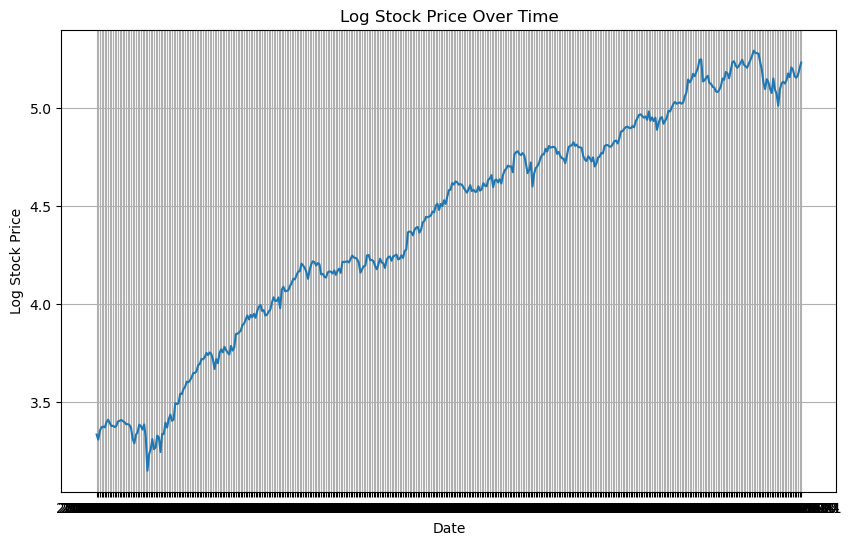

datetime64[ns]


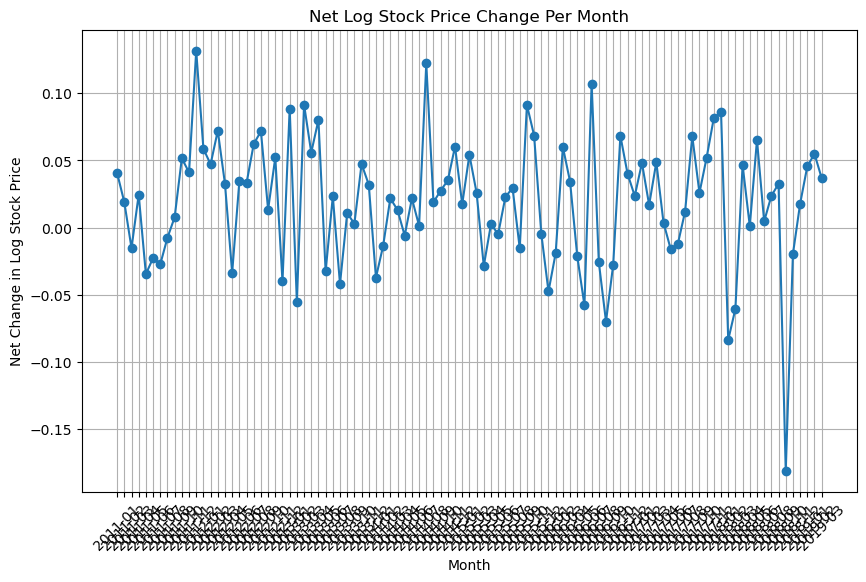

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# 
df = pd.read_csv("./midterm_data/data_train_midterm_problem1.csv")
df['log_stock_price'] = np.log(df['stock_price'])
df['raw_change'] = df['stock_price'].diff()
df['log_change'] = df['log_stock_price'].diff()
#
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['log_stock_price'])
plt.title('Log Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Log Stock Price')
plt.grid(True)
plt.show()
#
# plot average stock price for each month
# calculate net change in stock price per month 
df['date'] = pd.to_datetime(df['date'])
print(df['date'].dtype)
df['year_month'] = df['date'].dt.to_period('M')
month_means = df.groupby('year_month')['stock_price'].mean().reset_index()
month_changes = df.groupby('year_month')['log_change'].sum().reset_index()
#
plt.figure(figsize=(10, 6))
plt.plot(month_changes['year_month'].astype(str), month_changes['log_change'], marker='o')
plt.title('Net Log Stock Price Change Per Month')
plt.xlabel('Month')
plt.ylabel('Net Change in Log Stock Price')
plt.xticks(rotation=45)
plt.grid(True)
 # plt.show()

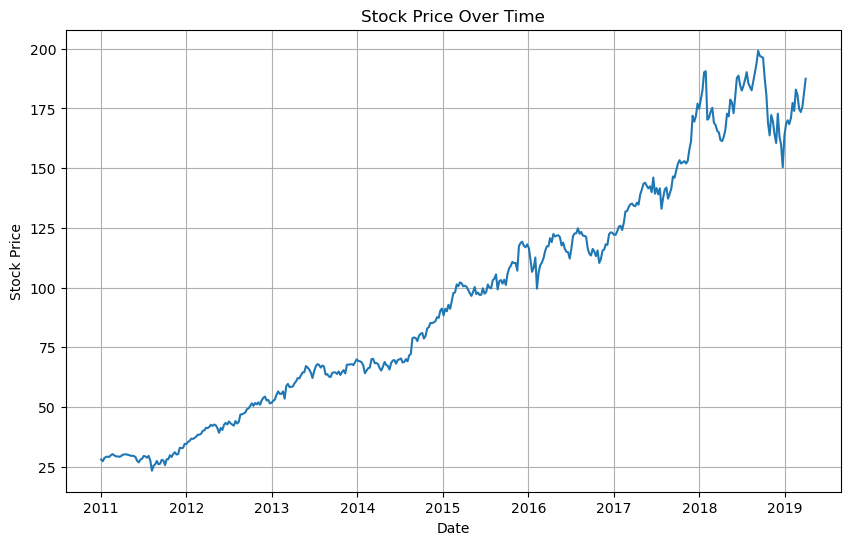

In [23]:
import matplotlib.pyplot as plt

# Plot stock prices
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['stock_price'])
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

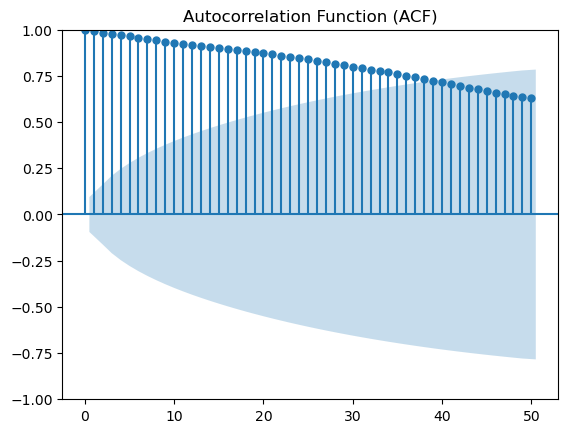

In [24]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function for the stock prices
plot_acf(df['stock_price'], lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()


In [25]:
## CHUNK DATA FRAME BEFORE CROSS VALIDATION STEP - I WANT A HOLDOUT SET ##
from sklearn.model_selection import train_test_split

# Split 
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.head()

,date,stock_price,log_stock_price,raw_change,log_change,year_month
132,2013-07-14,67.978508,4.219192,0.997696,0.014785,2013-07
227,2015-05-10,98.144043,4.586436,1.613808,0.016580,2015-05
31,2011-08-07,23.331295,3.149796,-4.290445,-0.168808,2011-08
84,2012-08-12,43.772915,3.779015,0.679558,0.015646,2012-08
347,2017-08-27,139.264099,4.936372,2.014572,0.014571,2017-08


In [26]:

#
# long length scale to manage gradual increase in mean
length = 50
rbf1 = 50.0**2 * RBF(length)

In [27]:
### Setting up a GP model

# convert datetime column to continuous so that it can be worked with more easily, as done in the volcano sklearn example
df['date'] = pd.to_datetime(df['date'])
reference_date = df['date'].min()
df['days_since_start'] = (df['date'] - reference_date).dt.days

# define data
x = df['days_since_start']
y = df['log_stock_price']

# split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [29]:
### Setting up a GP model

# convert datetime column to continuous so that it can be worked with more easily, as done in the volcano sklearn example
df['date'] = pd.to_datetime(df['date'])
reference_date = df['date'].min()
df['days_since_start'] = (df['date'] - reference_date).dt.days

# define data
x = df['days_since_start'].values.reshape(-1, 1)
y = df['log_stock_price']

# split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### define kernel and mean functions
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor

length = 50
k1 =  50.0**2 * RBF(length)
k2 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

#
kernel = ( k1 + k2 )
#

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
gaussian_process.fit(X_train, y_train - y_mean)

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1))